# **Finding Lane Lines on the Road** 
***
This notebook has piece together a very simple pipeline to detect the line segments in an image, then average/extrapolate them and draw them onto the image for display. The project makes use of Canny edge detection, Hough Transform, and RANSAC to find for each lane line a second order polynomio fit. Image and video data are tested and shown.

NOTE: To try your own dataset feel free to change input directory in the 'Read in Test Image' and 'Read in Test Video' sections.

<figure>
 <img src="Udacity_dataset/examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the Hough transform </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="Udacity_dataset/examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> To connect/average/extrapolate line segments we fit a 2nd order polynomio using RANSAC</p> 
 </figcaption>
</figure>

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
import warnings
from random import randint
%matplotlib inline

## Read in a Test Image
Our pipeline works with the images in the input directory "test_images".


 This image is: solidWhiteRight.jpg  of type  <class 'numpy.ndarray'> with dimensions: (540, 960, 3)

 This is the list of all images in Udacity_dataset/test_images : 



['solidYellowLeft.jpg',
 'solidYellowCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteCurve.jpg',
 'whiteCarLaneSwitch.jpg']

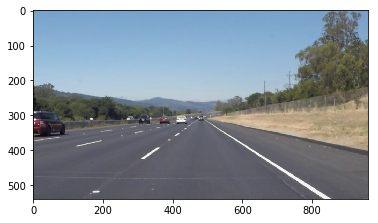

In [2]:
test_images_path = "Udacity_dataset/test_images"
test_images = os.listdir(test_images_path)

#reading in a random image
image = mpimg.imread(os.path.join(test_images_path, test_images[2])) #third image in this case

#printing out some stats and plotting
print('\n This image is:', test_images[2], ' of type ',type(image), 'with dimensions:', image.shape)
print('\n This is the list of all images in', test_images_path ,': \n')
plt.imshow(image)
test_images

## Helper Functions

Below are some helper functions that will be used in our pipeline.

In [3]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining the color mask channels according to input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def ransac_polyfit(x, y, order=2, n=15, k=100, t=15, d=10, f=0.5):
    """
    RANSAC: finds and returns best model coefficients
    n – minimum number of data points required to fit the model
    k – maximum number of iterations allowed in the algorithm
    t – threshold value to determine when a data point fits a model
    d – number of close data points required to assert that a model fits well to data
    f – fraction of close data points required
    """
    besterr = np.inf
    bestfit = None
    if len(x) > 0:            #if input data not empty
        for kk in range(k):
            maybeinliers = np.random.randint(len(x), size=n)
            maybemodel = np.polyfit(x[maybeinliers], y[maybeinliers], order)
            alsoinliers = np.abs(np.polyval(maybemodel,x)-y) < t
            if sum(alsoinliers) > d and sum(alsoinliers) > len(x)*f:
                bettermodel = np.polyfit(x[alsoinliers], y[alsoinliers], order)
                thiserr = np.sum(np.abs(np.polyval(bettermodel,x[alsoinliers])-y[alsoinliers]))
                if thiserr < besterr:
                    bestfit = bettermodel
                    besterr = thiserr
    return bestfit


def line_slope_classifier(lines, pts_per_line = 4):
    """
    Determine left and Right lines from Lane based on slope. Returns 4 int32 numpy arrays: x and y cordinates 
    from left and right lane lines respectively. Input must be a numpy array or list of tuples containing 
    2 pair of points that defines a single line, i.e., (x1,y1,x2,y2). 
    
    NOTE: This function gives you the option to add to the returning arrays more points than just the end
    points of a line through pts_per_line.
    """
    xl_lane = np.array([])
    yl_lane = np.array([])
    xr_lane = np.array([])
    yr_lane = np.array([])
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            line_model = np.polyfit((y1,y2),(x1,x2),1)
            y_values = np.linspace(y1, y2, pts_per_line, dtype=np.int32)
            x_hat_values = np.polyval(line_model, y_values).astype(np.int32)
            if line_model[0] < 0:     # if slope<0 then left_lane: since axis inverted in images
                yl_lane = np.append(yl_lane, y_values)
                xl_lane = np.append(xl_lane, x_hat_values)
            if line_model[0] > 0:
                yr_lane = np.append(yr_lane, y_values)
                xr_lane = np.append(xr_lane, x_hat_values)
                
    return xl_lane, yl_lane, xr_lane, yr_lane

def draw_roi_box(img, vertices, color=[0, 0, 255], thickness=5):
    """
    Draw a contour around region of interest on img 
    
    """
    # Create blank image: if not color yet then create "color" binary image
    if len(img.shape) == 2:         #if single channel
        img = np.dstack((img, img, img))
    img_to_draw = np.copy(img)*0
    
    # Draw the lines
    for vertex in vertices:   # used 'for' to get rid of 2D array
        cv2.line(img_to_draw, tuple(vertex[0]), tuple(vertex[1]), color, thickness)
        cv2.line(img_to_draw, tuple(vertex[1]), tuple(vertex[2]), color, thickness)
        cv2.line(img_to_draw, tuple(vertex[2]), tuple(vertex[3]), color, thickness)
        cv2.line(img_to_draw, tuple(vertex[3]), tuple(vertex[0]), color, thickness)
           
    # Add detected lanes to original img
    output_img = cv2.addWeighted(img_to_draw, 0.8, img, 1, 0) 
    return output_img
    

def draw_lines(img, lines, vertices, color=[255, 0, 0], thickness=2):
    """
    This function draws the left and right lines of the vehicles current lane with `color` and `thickness`. 
    Input must be an img, the vertices for the region of interest, and the output of the cv2.HoughLinesP function.
    
    """
    # Create blank image: if not color yet then create "color" binary image
    if len(img.shape) == 2:         #if binary channel
        img = np.dstack((img, img, img))
    img_to_draw = np.copy(img)*0
    
    # Determine left and Right Lanes based on slope
    xl_lane, yl_lane, xr_lane, yr_lane = line_slope_classifier(lines)
    
    # Apply Ransac second order polynomial 
    left_lane_model = ransac_polyfit( yl_lane, xl_lane)  # switch order since parabola is vertical
    right_lane_model = ransac_polyfit( yr_lane, xr_lane)
    #print("right_lane_model: ", right_lane_model," left_lane_model: ", left_lane_model)
        
    # Fit left and right lane parabola to data
    y_values = np.arange(img.shape[0]/2,img.shape[0], dtype=np.int32)   #choose y values to evaluate with model
    xl_hat_lane, xr_hat_lane = None, None
    if left_lane_model is not None: xl_hat_lane = np.polyval(left_lane_model, y_values).astype(np.int32)
    if right_lane_model is not None: xr_hat_lane = np.polyval(right_lane_model, y_values ).astype(np.int32)
    
    # Draw lanes on blank image
    if  xl_hat_lane is not None:               #Takes care of cases when a lane is not present in image
        for cx,cy in zip(xl_hat_lane, y_values):
            cv2.circle(img_to_draw, (cx,cy), radius= 1, color=color, thickness=thickness)
    if xr_hat_lane is not None:
        for cx,cy in zip(xr_hat_lane, y_values):
            cv2.circle(img_to_draw, (cx,cy), radius= 1, color=color, thickness=thickness)    
    img_to_draw = region_of_interest(img_to_draw, vertices)
            
    # Merge detected lanes to original img
    output_img = cv2.addWeighted(img_to_draw, 0.8, img, 1, 0) 
    return output_img


def draw_hough_lines(img, lines, thickness=5):
    """
    Adds hough lines to img but with random color to visually identify all lines.  
    Input must be an img and the output of the cv2.HoughLinesP function, i.e.,a numpy array of 
    numpy arrays containing 2 pair of points that defines a single line, e.g., (x1,y1,x2,y2)
    
    """
    # Create blank image: if not color yet then create "color" binary image
    if len(img.shape) == 2:         #if binary channel
        img = np.dstack((img, img, img))
    img_to_draw = np.copy(img)*0
   
    # Iterate over the output "lines" and draw lines on a blank image
    for line in lines:
        x1,y1,x2,y2 = line[0]      #it only has one value made of four variables
        cv2.line(img_to_draw,(x1,y1),(x2,y2),(randint(0, 255),randint(0, 255),randint(0, 255)),thickness)
  
    # Add detected lanes to original img
    output_img = cv2.addWeighted(img_to_draw, 0.8, img, 1, 0) 
    return output_img



## Lane Detector Pipeline
Makes use of helper functions to return image with lanes detected.

In [4]:
def lane_detector(image):
    """"
    Returns a color image with lanes detected. Input must be a color image.
    
    """    
    #Convert to gray, and apply gaussian blur
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY) 
    blur_gray = cv2.GaussianBlur(gray,(5,5),0)

    # Apply Canny Edge Detection
    low_threshold = 50
    high_threshold = 150
    canny = cv2.Canny(blur_gray, low_threshold, high_threshold)

    # Obtain region of interest from canny image by defining vertices of polygon
    imshape = image.shape
    bottom_left =(int(0.05*imshape[1]),imshape[0]) 
    upper_left =(imshape[1]/2-50,imshape[0]/2+50)
    upper_right = (imshape[1]/2+50,imshape[0]/2+50)
    bottom_right =(int(0.95*imshape[1]),imshape[0])
    vertices = np.array([[bottom_left,upper_left,upper_right,bottom_right]], dtype=np.int32)
    roi_canny = region_of_interest(canny, vertices)

    # Apply Hough transform to roi of canny image
    rho = 2                # distance resolution in pixels of the Hough grid
    theta = np.pi/180      # angular resolution in radians of the Hough grid
    threshold = 20          # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20   # minimum number of pixels making up a line
    max_line_gap = 20      # maximum gap in pixels between connectable line segments of min_line_length
    lines = cv2.HoughLinesP(roi_canny, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)

    # (OPTIONAL) Draw Hough lines on canny image
    #canny_hough_lines = draw_hough_lines(roi_canny, lines)
    #return canny_hough_lines

    # (OPTIONAL) Draw lanes and roi box on canny image
    #canny_lane = draw_lines(roi_canny, lines, vertices, color = [255, 0, 0], thickness = 15)
    #canny_lane = draw_roi_box(canny_lane, vertices)
    #return canny_lanes
    
    #Draw lanes and roi box on original image
    image_lane = draw_lines(image, lines, vertices, color = [255, 0, 0], thickness = 10)
    image_lane = draw_roi_box(image_lane, vertices)
    #image_lanes = draw_hough_lines(image_lane, lines)
    return image_lane  

Run pipeline on all test_images and place results into the `test_images_output` directory.

Output Folder is ready already


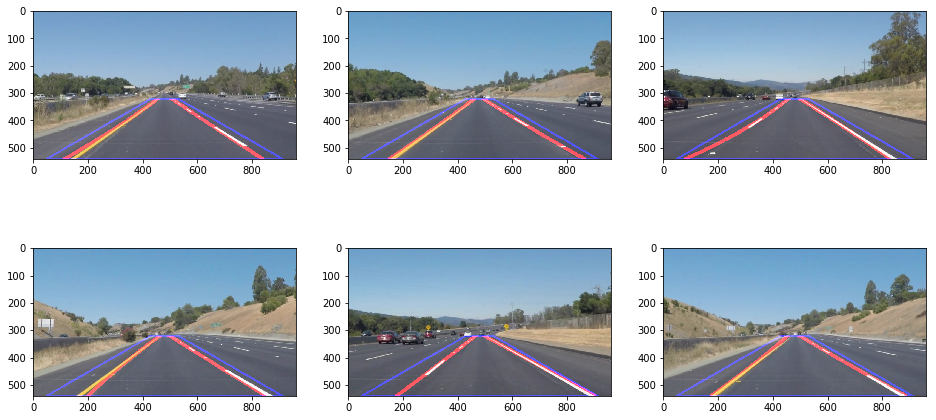

In [25]:
# Comment next line to see warning messages in this cell
warnings.simplefilter('ignore')

# Create folder to place output images at same level directory as input folder
try:
    test_images_output_path = test_images_path + "_output"
    os.mkdir(test_images_output_path)

except FileExistsError:
    print ("Output Folder is ready already")

             
# Detect Lanes: Plot and save output results
plt.figure(figsize=(16, 8))
for i in range(len(test_images)):
    img_path = os.path.join(test_images_path, test_images[i])
    dest_path = os.path.join(test_images_output_path, test_images[i])
    
    image = mpimg.imread(img_path)
    lane_image = lane_detector(image)
    mpimg.imsave(dest_path,lane_image)
    
    plt.subplot(2,3,i+1)
    plt.imshow(lane_image)   

# Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video! We will test our solution on three provided videos. 

**Make sure you have run all previous cells before running the video section**

`solidWhiteRight.mp4`
`solidYellowLeft.mp4`
`challenge.mp4'`

## Import Remaining Packages

In [21]:
%%capture
# %%capture is used to ignore output when content is boring.
# Install the following only if you do not have it. It contains VideoFileClip module needed in the next cell. 
!pip3 install -U imageio-ffmpeg      #This is how you install modules from jupyter notebook instead of terminal

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Read in Test Videos

In [8]:
test_video_path = "Udacity_dataset/test_videos"
test_video_output_path = test_video_path + "_output"

# Create folder to place output videos at same level directory as input folder
try:
    os.mkdir(test_video_output_path)
except FileExistsError:
    print ("Output Folder is ready already")

# Just a change of name for clarity    
def process_image(image):
    return lane_detector(image)

Output Folder is ready already


## Solid White Line Example
Let's try the video with the solid white lane on the right first ... 

In [16]:
%%capture
video_path = os.path.join(test_video_path , 'solidWhiteRight.mp4')
dest_path = os.path.join(test_video_output_path , 'solidWhiteRight.mp4')

# To speed up the testing process uncomment the following line for a subclip of the first 5 seconds 
#clip = VideoFileClip(video_path).subclip(0,5)    # .subclip(start_second,end_second) 
clip = VideoFileClip(video_path)
video_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time video_clip.write_videofile(dest_path, audio=False)

100%|█████████▉| 221/222 [00:34<00:00,  5.82it/s]


**Play the video inline by running the following cell, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.**

In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(dest_path))

## Solid Yellow Lane Example
Now for the one with the solid yellow lane on the left. This one's more tricky!

In [11]:
%%capture
video_path = os.path.join(test_video_path , 'solidYellowLeft.mp4')
dest_path = os.path.join(test_video_output_path , 'solidYellowLeft.mp4')

clip = VideoFileClip(video_path)
video_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time video_clip.write_videofile(dest_path, audio=False)

100%|█████████▉| 681/682 [01:52<00:00,  5.88it/s]


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(dest_path))

## Challenge Video (Discovering issues)
From this video you identify that the techniques implemented are good for determining lines on on the road but has issues extrapolating those lines. line_slope_classifier function needs improvement since it fails when the lane curves. Also the second order polinomial line models for each line should share the same `a` coefficient in ay^2+by+c since both lines curve in the same direction. We will deal with this issues in our next repo.

In [17]:
%%capture
video_path = os.path.join(test_video_path , 'challenge.mp4')
dest_path = os.path.join(test_video_output_path , 'challenge.mp4')

clip = VideoFileClip(video_path)
video_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time video_clip.write_videofile(dest_path, audio=False)

100%|██████████| 251/251 [01:07<00:00,  3.71it/s]


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(dest_path))